In [1]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
%matplotlib inline
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:80% !important; }</style>")) 

In [2]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

# Utility functions

In [3]:
def plot_missingness_heatmap(df):
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

def count_null_rows(df):
    return df.isnull().sum()

# Import custom-built probabilistic matrix factorization (PMF) module

In [3]:
cwd = os.getcwd()
path = os.path.join(cwd, '..', 'src')
if not path in sys.path:
    sys.path.append(path)
del cwd, path

In [4]:
from MovieRecommender import PMF

# Load ratings data

In [5]:
cwd = os.getcwd()
ratings = pd.read_csv(os.path.join(cwd, "..", "data", "ratings.csv"))

In [6]:
ratings.shape

(20000263, 4)

In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [8]:
ratings.drop('timestamp', axis=1, inplace=True)

In [9]:
ratings.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


# Reduce data size to facilitate testing

In [10]:
ratings_red = ratings.sample(100000, random_state=14113).copy()

In [11]:
ratings_red.shape

(100000, 3)

# Create test-train split

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
ratings_train, ratings_test = train_test_split(ratings_red, test_size=0.3, random_state=14113)

In [14]:
ratings_train.shape, ratings_test.shape

((70000, 3), (30000, 3))

# Grid Search hyperparameter space for ideal setting
Hyperparameters to tune:
1. Rank
2. Lambda
3. Variance

In [15]:
def get_RMSE(df_in):
    df = df_in.dropna()
    return np.sqrt(((df['rating'] - df['prediction'])**2).mean())

## Search #1

In [20]:
lamd_search = [0.1, 1.0, 5.0]
sig2_search = [0.05, 0.5, 2.0]

In [23]:
num_iter = len(lamd_search) * len(sig2_search)
i = 0
results = []
pmf = PMF(num_iter=50, rank=10)
for lamd in lamd_search:
    for sig2 in sig2_search:
        i += 1
        print('\niteration {} of {} | lambda={} | sig2={}'.format(i, num_iter, lamd, sig2))
        pmf.lamd = lamd; pmf.sig2 = sig2
        pmf.fit(ratings_train, force_refresh=False)
        preds = pmf.predict(ratings_test)
        results.append((lamd, sig2, pmf.L[-1], get_RMSE(preds)))


iteration 1 of 9 | lambda=0.1 | sig2=0.05
force_refresh is set to: False
user ids normalized: False | object ids normalized: False
Normalizing user ids | 2017-08-08 12:17:48.936368
saving user_mapping.csv to cwd
Normalizing object ids | 2017-08-08 12:17:55.053154
saving obj_mapping.csv to cwd
building omega | 2017-08-08 12:17:56.538002
building omega_u | 2017-08-08 12:17:56.602968
building omega_v | 2017-08-08 12:18:03.531568
building the matrix dictionary M | 2017-08-08 12:18:05.079281
beginning training epochs | 2017-08-08 12:18:05.419660

iteration 2 of 9 | lambda=0.1 | sig2=0.5
force_refresh is set to: False
beginning training epochs | 2017-08-08 12:21:01.190555

iteration 3 of 9 | lambda=0.1 | sig2=2.0
force_refresh is set to: False
beginning training epochs | 2017-08-08 12:23:49.830909

iteration 4 of 9 | lambda=1.0 | sig2=0.05
force_refresh is set to: False
beginning training epochs | 2017-08-08 12:26:32.523842

iteration 5 of 9 | lambda=1.0 | sig2=0.5
force_refresh is set to: 

In [24]:
results_df = pd.DataFrame(results, columns=['lambda', 'variance', 'L', 'testRMSE'])

In [25]:
results_df

,lambda,variance,L,testRMSE
0,0.1,0.05,-9088.411364,4.288897
1,0.1,0.50,-6347.216999,4.015001
2,0.1,2.00,-5368.491827,3.855574
3,1.0,0.05,-63697.935079,4.018522
4,1.0,0.50,-50452.481239,3.173875
5,1.0,2.00,-44927.202490,2.069514
6,5.0,0.05,-263313.380266,3.676290
7,5.0,0.50,-217450.151250,1.957605
8,5.0,2.00,-146108.922148,2.264561


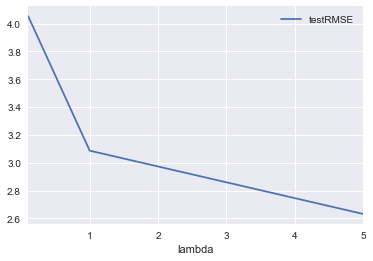

In [26]:
results_df.groupby('lambda').agg({'testRMSE':'mean'}).plot()

## Search #2

In [16]:
def grid_search(lamd_search, sig2_search):
    num_iter = len(lamd_search) * len(sig2_search)
    i = 0
    results = []
    pmf = PMF(num_iter=50, rank=10)
    for lamd in lamd_search:
        for sig2 in sig2_search:
            i += 1
            print('\niteration {} of {} | lambda={} | sig2={}'.format(i, num_iter, lamd, sig2))
            pmf.lamd = lamd; pmf.sig2 = sig2
            pmf.fit(ratings_train, force_refresh=False)
            preds = pmf.predict(ratings_test)
            results.append((lamd, sig2, pmf.L[-1], get_RMSE(preds)))
    return pd.DataFrame(results, columns=['lambda', 'variance', 'L', 'testRMSE'])

In [17]:
lamd_search = [5, 7.5, 10, 12.5]
sig2_search = [0.25, 0.5, 0.75]

In [18]:
results_df2 = grid_search(lamd_search, sig2_search)


iteration 1 of 12 | lambda=5 | sig2=0.25
force_refresh is set to: False
user ids normalized: False | object ids normalized: False
Normalizing user ids | 2017-08-08 13:29:28.344984
saving user_mapping.csv to cwd
Normalizing object ids | 2017-08-08 13:29:34.336479
saving obj_mapping.csv to cwd
building omega | 2017-08-08 13:29:35.804498
building omega_u | 2017-08-08 13:29:35.873529
building omega_v | 2017-08-08 13:29:42.397246
building the matrix dictionary M | 2017-08-08 13:29:43.746703
beginning training epochs | 2017-08-08 13:29:44.039654

iteration 2 of 12 | lambda=5 | sig2=0.5
force_refresh is set to: False
beginning training epochs | 2017-08-08 13:32:32.998965

iteration 3 of 12 | lambda=5 | sig2=0.75
force_refresh is set to: False
beginning training epochs | 2017-08-08 13:35:24.806677

iteration 4 of 12 | lambda=7.5 | sig2=0.25
force_refresh is set to: False
beginning training epochs | 2017-08-08 13:38:17.777462

iteration 5 of 12 | lambda=7.5 | sig2=0.5
force_refresh is set to: 

In [19]:
results_df2

,lambda,variance,L,testRMSE
0,5.0,0.25,-236265.940606,2.311567
1,5.0,0.50,-217476.743616,1.966123
2,5.0,0.75,-201323.466805,1.925223
3,7.5,0.25,-339651.539731,2.066001
4,7.5,0.50,-302003.989876,1.924296
5,7.5,0.75,-271284.050337,1.974499
6,10.0,0.25,-434953.597670,1.973342
7,10.0,0.50,-374458.553712,1.949496
8,10.0,0.75,-328313.196079,2.089010
9,12.5,0.25,-522845.352181,1.933189


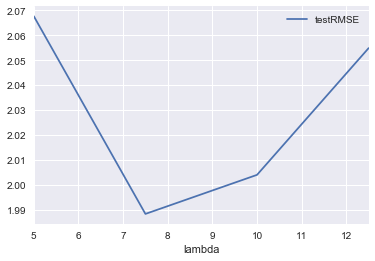

In [20]:
results_df2.groupby('lambda').agg({'testRMSE':'mean'}).plot()

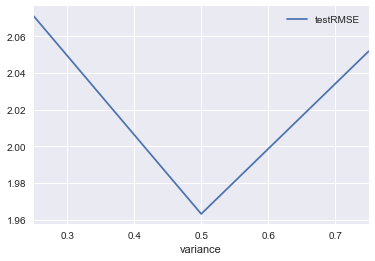

In [22]:
results_df2.groupby('variance').agg({'testRMSE':'mean'}).plot()

## Search #3

In [25]:
lamd_search = [7.5]
sig2_search = [0.1, 0.25, 0.375, 0.5, 0.625, 0.75, 1.0, 1.25, 1.50, 2.0]

In [26]:
results_df3 = grid_search(lamd_search, sig2_search)


iteration 1 of 10 | lambda=7.5 | sig2=0.1
force_refresh is set to: False
user ids normalized: False | object ids normalized: False
Normalizing user ids | 2017-08-08 14:10:58.880163
saving user_mapping.csv to cwd
Normalizing object ids | 2017-08-08 14:11:05.578933
saving obj_mapping.csv to cwd
building omega | 2017-08-08 14:11:07.163324
building omega_u | 2017-08-08 14:11:07.234015
building omega_v | 2017-08-08 14:11:14.270132
building the matrix dictionary M | 2017-08-08 14:11:15.670441
beginning training epochs | 2017-08-08 14:11:15.989807

iteration 2 of 10 | lambda=7.5 | sig2=0.25
force_refresh is set to: False
beginning training epochs | 2017-08-08 14:14:13.790517

iteration 3 of 10 | lambda=7.5 | sig2=0.375
force_refresh is set to: False
beginning training epochs | 2017-08-08 14:17:15.036139

iteration 4 of 10 | lambda=7.5 | sig2=0.5
force_refresh is set to: False
beginning training epochs | 2017-08-08 14:20:10.664104

iteration 5 of 10 | lambda=7.5 | sig2=0.625
force_refresh is 

In [27]:
results_df3

,lambda,variance,L,testRMSE
0,7.5,0.100,-367878.733198,2.636696
1,7.5,0.250,-339695.933694,2.085529
2,7.5,0.375,-319872.490786,1.945482
3,7.5,0.500,-301990.473293,1.919758
4,7.5,0.625,-285858.072276,1.945174
5,7.5,0.750,-271289.956184,1.974898
6,7.5,1.000,-246228.307803,2.087389
7,7.5,1.250,-225367.929296,2.219241
8,7.5,1.500,-207689.558388,2.357638
9,7.5,2.000,-179254.698996,2.630732


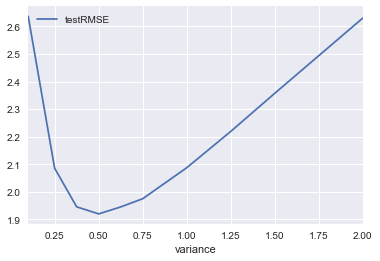

In [29]:
results_df3.groupby('variance').agg({'testRMSE':'mean'}).plot()

# Results
- **rank** = 10
- **lambda** = 7.5
- **variance** = 0.5